In [4]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import os 
# Set plot style
sns.set(style='whitegrid')
%matplotlib inline


In [ ]:
data_path=os.path.join('../data/pilot_data/','sub-01_ses-001_raw_preprocessed_GonoGo_noEpoched.fif')
raw=mne.io.read_raw_fif(data_path,preload=True)
raw=raw.filter(1,30)

Opening raw data file ../data/pilot_data/sub-01_ses-001_raw_preprocessed_GonoGo_noEpoched.fif...
    Range : 81028 ... 385484 =    270.093 ...  1284.947 secs
Ready.
Reading 0 ... 304456  =      0.000 ...  1014.853 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 991 samples (3.303 s)



C:\Users\s\AppData\Local\Temp\ipykernel_28008\3866854076.py:2: RuntimeWarning: This filename (../data/pilot_data/sub-01_ses-001_raw_preprocessed_GonoGo_noEpoched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif(data_path,preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [16]:
# Define your event IDs based on the trigger list
event_id = {
    'Go': 1,
    'NoGo': 2,
    'Correct': 3,
    'Incorrect': 4
}

# Replace 'STI 014' with your actual stimulus channel name if different
events = mne.find_events(raw, stim_channel='Trigger')

# Display the first few events
print(events[:10])
# Initialize lists to store new events and their IDs
new_events = []
new_event_id = {
    'Go_Correct': 101,
    'Go_Incorrect': 102,
    'NoGo_Correct': 201,
    'NoGo_Incorrect': 202
}

# Iterate through events to combine onset and response triggers
i = 0 
while i < len(events) - 1:
    onset_event = events[i]
    response_event = events[i + 1]
    
    onset = onset_event[2]
    response = response_event[2]
    
    # Check if the current event is an onset trigger and the next is a response trigger
    if onset in [1, 2] and response in [3, 4]:
        if onset == 1 and response == 3:
            new_events.append([onset_event[0], 0, new_event_id['Go_Correct']])
        elif onset == 1 and response == 4:
            new_events.append([onset_event[0], 0, new_event_id['Go_Incorrect']])
        elif onset == 2 and response == 3:
            new_events.append([onset_event[0], 0, new_event_id['NoGo_Correct']])
        elif onset == 2 and response == 4:
            new_events.append([onset_event[0], 0, new_event_id['NoGo_Incorrect']])
        # Skip the response event in the next iteration
        i += 2
    else:
        # If not a valid onset-response pair, skip to the next event
        i += 1

# Convert to numpy array
new_events = np.array(new_events)

# Display the first few new events
print(new_events[:10])


Trigger channel Trigger has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1198 events found on stim channel Trigger
Event IDs: [1 2 3 4 8 9]
[[81043     7     8]
 [81636     0     2]
 [82826     0     3]
 [82982     0     1]
 [83194     0     1]
 [83490     0     3]
 [83648     0     1]
 [83821     0     1]
 [84117     0     3]
 [84276     0     1]]
[[81636     0   201]
 [83194     0   101]
 [83821     0   101]
 [84409     0   101]
 [84865     0   201]
 [86346     0   101]
 [86927     0   101]
 [87498     0   101]
 [88848     0   201]
 [89438     0   101]]


Not setting metadata
396 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 396 events and 301 original time points ...
0 bad epochs dropped
<Epochs | 396 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~19.1 MB, data loaded,
 'Go_Correct': 300
 'NoGo_Correct': 96>


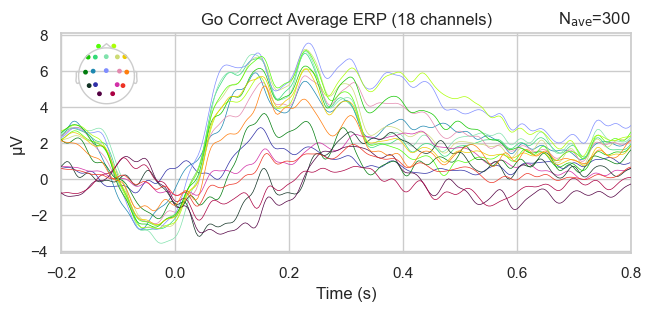

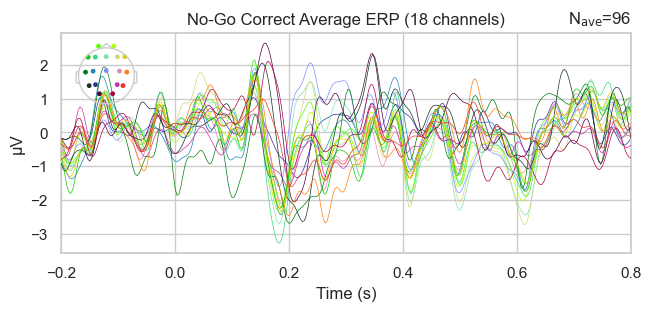

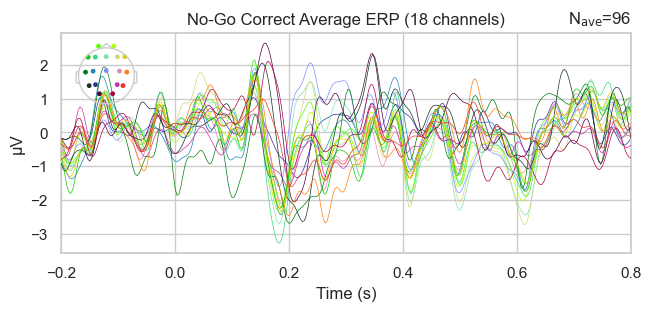

In [17]:
# Define combined event IDs for epoching
combined_event_id = {
    'Go_Correct': 101,
    'NoGo_Correct': 201
}

# Define epoch parameters
tmin = -0.2
tmax = 0.8
baseline = (None, 0)

# Create epochs for correct responses only
epochs_correct = mne.Epochs(raw, new_events, event_id=combined_event_id, tmin=tmin, tmax=tmax,
                            baseline=baseline, preload=True, verbose=True)
print(epochs_correct)

# Plot average ERPs
evoked_go_correct = epochs_correct['Go_Correct'].average()
evoked_go_correct.plot(titles='Go Correct Average ERP', spatial_colors=True)

evoked_nogo_correct = epochs_correct['NoGo_Correct'].average()
evoked_nogo_correct.plot(titles='No-Go Correct Average ERP', spatial_colors=True)

# Define ROIs and Combine Channels 

In [18]:
# Define channel names for Middle and Back ROIs
middle_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'C3', 'C4', 'Cz']
back_channels = ['P3', 'P4', 'O1', 'O2']

# Select channel indices for Middle and Back ROIs
middle_ix = mne.pick_channels(raw.info["ch_names"], include=middle_channels)
back_ix = mne.pick_channels(raw.info["ch_names"], include=back_channels)

# Define a dictionary mapping ROI names to their respective channel indices
roi_dict = {
    'Middle_ROI': middle_ix,
    'Back_ROI': back_ix
}

# Combine channels within each ROI by averaging for Go_Correct condition
roi_evoked_go = mne.channels.combine_channels(epochs_correct['Go_Correct'].average(), roi_dict, method="mean")

# Combine channels within each ROI by averaging for NoGo_Correct condition
roi_evoked_nogo = mne.channels.combine_channels(epochs_correct['NoGo_Correct'].average(), roi_dict, method="mean")

# Display the new channel names to confirm
print("Virtual ROI channels for Go_Correct:", roi_evoked_go.info["ch_names"])
print("Virtual ROI channels for NoGo_Correct:", roi_evoked_nogo.info["ch_names"])


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Virtual ROI channels for Go_Correct: ['Middle_ROI', 'Back_ROI']
Virtual ROI channels for NoGo_Correct: ['Middle_ROI', 'Back_ROI']


# Plotting the ERPs in different ROIs

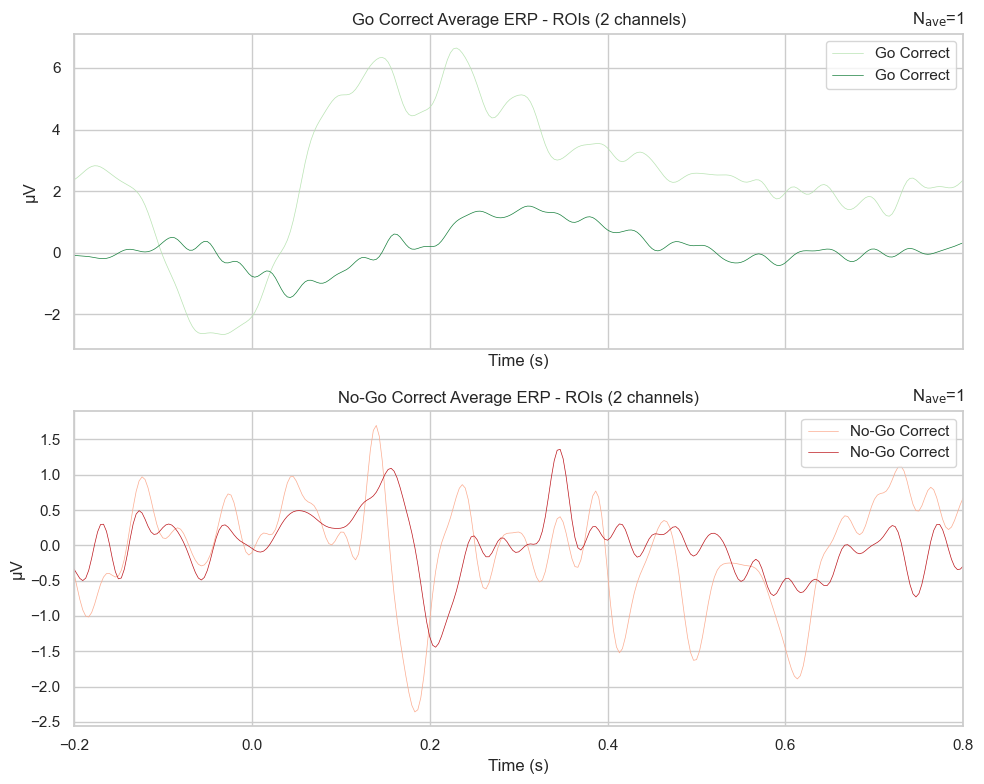

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Go Correct ERP
roi_evoked_go.plot(axes=axes[0], spatial_colors=False, show=False,
                   titles=dict(eeg='Go Correct Average ERP - ROIs'))

# Get all line objects from the Go plot
lines_go = axes[0].get_lines()
# Generate a sequence of colors from the 'Greens' colormap
greens = plt.cm.Greens(np.linspace(0.3, 0.8, len(lines_go)))
# Apply these colors to the lines
for line, color in zip(lines_go, greens):
    line.set_color(color)
axes[0].legend(lines_go, ['Go Correct'] * len(lines_go), loc='upper right')

# Plot No-Go Correct ERP
roi_evoked_nogo.plot(axes=axes[1], spatial_colors=False, show=False,
                     titles=dict(eeg='No-Go Correct Average ERP - ROIs'))

# Get all line objects from the No-Go plot
lines_nogo = axes[1].get_lines()
# Generate a sequence of colors from the 'Reds' colormap
reds = plt.cm.Reds(np.linspace(0.3, 0.8, len(lines_nogo)))
# Apply these colors to the lines
for line, color in zip(lines_nogo, reds):
    line.set_color(color)
axes[1].legend(lines_nogo, ['No-Go Correct'] * len(lines_nogo), loc='upper right')

plt.tight_layout()
plt.show()


# Compare Go vs. No-Go ERPs for Different ROIs

combining channels using "mean"
combining channels using "mean"


C:\Users\s\AppData\Local\Temp\ipykernel_28008\84834501.py:17: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\s\AppData\Local\Temp\ipykernel_28008\84834501.py:17: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


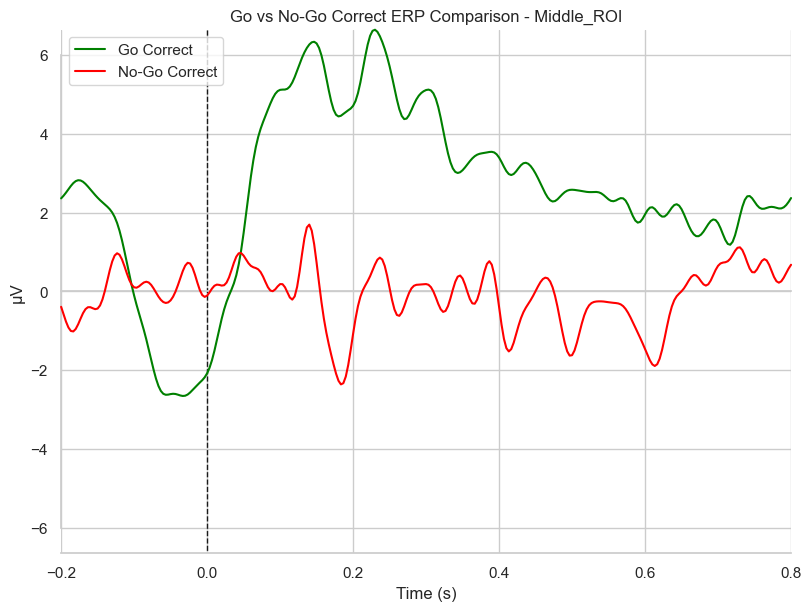

<Figure size 640x480 with 0 Axes>

combining channels using "mean"
combining channels using "mean"


C:\Users\s\AppData\Local\Temp\ipykernel_28008\84834501.py:30: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\s\AppData\Local\Temp\ipykernel_28008\84834501.py:30: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


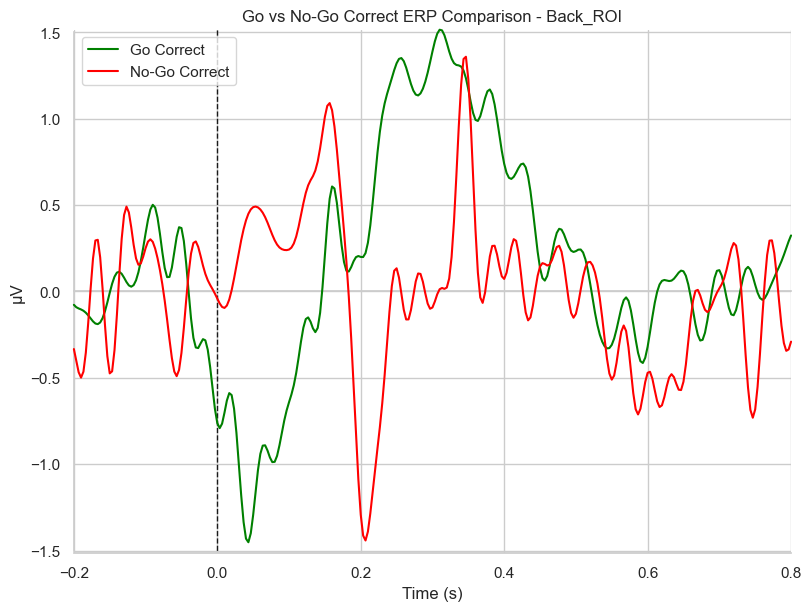

<Figure size 640x480 with 0 Axes>

In [20]:
# Create a dictionary of Evoked objects for comparison
evokeds_compare = {
    'Go Correct': roi_evoked_go,
    'No-Go Correct': roi_evoked_nogo
}

# Define custom colors for each condition
colors_compare = {
    'Go Correct': 'green',
    'No-Go Correct': 'red'
}

# Define the ROIs to include in the comparison
picks_roi = ['Back_ROI']

# Create a figure with subplots for each ROI
mne.viz.plot_compare_evokeds(
    evokeds_compare,
    picks='Middle_ROI',  # Only plot the Back_ROI
    combine='mean',  # Average if multiple channels are present
    colors=colors_compare,  
    title=f'Go vs No-Go Correct ERP Comparison - Middle_ROI'
)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
    
# Create a figure with subplots for each ROI
mne.viz.plot_compare_evokeds(
    evokeds_compare,
    picks='Back_ROI',  # Only plot the Back_ROI
    combine='mean',  # Average if multiple channel           s are present
    colors=colors_compare,
    title=f'Go vs No-Go Correct ERP Comparison - Back_ROI'
)

# Adjust layout and display the plots               
plt.tight_layout()
plt.show()

